# Домашнее задание «Проблема качества данных»

In [2]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

## Загрузка данных

In [3]:
df = pd.read_csv('data/train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Признаки: 
- **PassengerId**. Это просто порядковый номер пассажира в таблице, естесствено не берем в качестве предиктора. 
- **Survived**. Выжил (1)  или погиб (0). Это целевой признак.
- **Pclass**. Класс пассажира. Большое влияение на "выживаемость", берем в качестве предиктора.
- **Name**. Имя пассажира, маловероятно, что играет роль в предсказании, не берем. Хотя, если бы не было признака пол в данных, то отсюда можно было бы его вытащить.
- **Sex**. Пол пассажира. Берем обязательно.
- **Age** . Возраст пассажира. Берем.
- **SibSp**. Число братьев, сестер или супругов на борту. Точно не уверен, но попробуем учесть и этот фактор.
- **Parch**. Число родителей или детей на борту. Аналогично.
- **Ticket**. Номер билета. Вряд ли это полезный признак.
- **Fare**. Стоимость билета. Скорее всего играет роль: большая стоимость, значит выше класс, и больше шансов выжить, скорее всего коррелирует с признаком Pclass, проверим.
- **Cabin** . Каюта. Сложно сказать, но в любом случае тут очень много пропусков, скорее всего, этот признак не берем в расчет.
- **Embarked**. Пункт посадки. Не уверен, но поробуем взят в модель.

In [393]:
# получается такой список признаков
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

Для наглядности результаты будем записывать в таблицу

In [394]:
results = pd.DataFrame(columns=['method', 'preprocessing', 'accuracy', 'f1', 'roc-auc'])
results

,method,preprocessing,accuracy,f1,roc-auc


## Обучение без предобработки данных

In [395]:
# избавимся от признака Cabin, так как там слишком много пропусков
df.drop('Cabin', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [396]:
# теперь очистим данные от строк с NaN
df.dropna(inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [397]:
# целевой признак
y = df.Survived
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [398]:
# признаки
X = df[features]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [399]:
# категориальные столбцы переведем в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [400]:
# разобьем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Будем прогонять данные (и без обработки и после нее) через несколько методов машинного обучения, параметры оставим по умолчанию во всех случаях. Для удобства все это оформим в виде функции:

In [401]:
def experiment(X_train,y_train, comment):
    
    # модели
    models = [LogisticRegression(), 
              SVC(probability=True), 
              LinearDiscriminantAnalysis(),
              DecisionTreeClassifier(),
              RandomForestClassifier()]
    name = ['LogReg',
            'SVC',
            'LDA',
            'DecTree',
            'RandForest'
            ]          

    for m, n in zip(models, name):

        #создаем пайплайн
        model = make_pipeline(StandardScaler(), m)

        # обучаем
        model.fit(X_train,y_train)
        
        # предсказанные значения целевого признака
        y_pred = model.predict(X_test)

        # вероятности принадлежности к классам 0 и 1
        y_pred_prob = model.predict_proba(X_test)

        # метрика accuracy
        acc_ = model.score(X_test,y_test)

        # f1-метрика
        f1_ = f1_score(y_test, y_pred)

        # roc_auc_score
        roc_ = roc_auc_score(y_test, y_pred_prob[:,1])

        # запишем результаты в таблицу
        results.loc[len(results.index)] = [n, comment,  acc_, f1_, roc_]

In [402]:
comment='no'
experiment(X_train,y_train, comment)

## Обучение с подготовкой данных, версия 1

Заново загрузим данные и теперь уже займемся их обработкой перед обучением.

Поработаем с признаком Age

In [403]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [404]:
# также избавимся от признака Cabin
df.drop('Cabin', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [406]:
# кол-во пропусков по признакам
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [407]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [408]:
# Проверка на дубли
df.duplicated().sum()

0

Повторяющихся записей нет.

**Признак Age**. Есть пропуски. Если просто удалить строки с пропусками, то потеряем слишком много данных:

In [409]:
print(f'потеряем {len(df)} - {df.Age.count()} = {len(df) - df.Age.count()} ({round((len(df) - df.Age.count())/len(df)*100, 2)}% данных)')

потеряем 891 - 714 = 177 (19.87% данных)


Можно найти средний возраст в зависимости от класса и пола. И вставить соответсвующие значения в пропуски.

In [410]:
age_ = df.groupby(['Pclass','Sex'])['Age'].mean()
age_

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

Видно, что средний возраст по классам отличается. Чем ниже класс, тем моложе средний возраст пассажиров. Что логично, в первый класс билеты дороже и позволить его могут более старшие и состоятельные люди.

In [411]:
# подставим полученные значения вместо пропусков

df.loc[ (df.Age.isnull()) & (df.Pclass == 1) & (df.Sex == 'female'), 'Age'] = age_[1][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 1) & (df.Sex == 'male'), 'Age'] = age_[1][1]

df.loc[ (df.Age.isnull()) & (df.Pclass == 2) & (df.Sex == 'female'), 'Age'] = age_[2][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 2) & (df.Sex == 'male'), 'Age'] = age_[2][1]

df.loc[ (df.Age.isnull()) & (df.Pclass == 3) & (df.Sex == 'female'), 'Age'] = age_[3][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 3) & (df.Sex == 'male'), 'Age'] = age_[3][1]

In [412]:
# убедимся что основные статистики признака не сильно изменились
df.Age.describe()

count    891.000000
mean      29.318643
std       13.281103
min        0.420000
25%       21.750000
50%       26.507589
75%       36.000000
max       80.000000
Name: Age, dtype: float64

**Признак Embarked**, всего два пропуска, заменим модой.

In [413]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [414]:
embarked_ = df.Embarked.mode()
embarked_

0    S
dtype: object

In [415]:
df.Embarked[df.Embarked.isnull()]

61     NaN
829    NaN
Name: Embarked, dtype: object

In [416]:
# подстановка
df.loc[ df.Embarked.isnull(), 'Embarked'] = embarked_[0]

In [417]:
df.Embarked.describe()

count     891
unique      3
top         S
freq      646
Name: Embarked, dtype: object

### Визуальный анализ данных

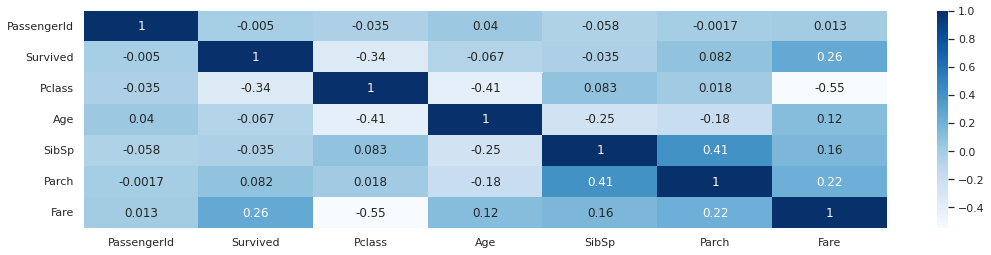

In [418]:
sns.heatmap(df.corr(), cmap="Blues", annot=True)

Было предположение о том, что между классом пассажира и стоимостью билета есть зависимость. По карте видно что она есть, но не такая большая, поэтому можно оставить оба признака.

0    549
1    342
Name: Survived, dtype: int64


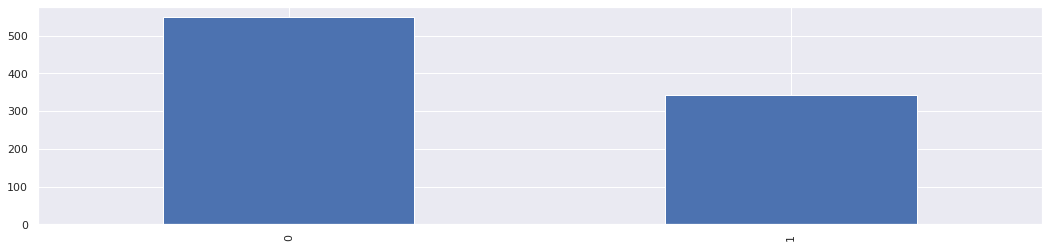

In [419]:
# соотношение выживших и погибших
print(df.Survived.value_counts())
df.Survived.value_counts().plot.bar()

Количество выживших и погибших одного порядка, но все же есть разница в количестве (около 60%). Поэтому для надежности лучше пользоваться метриками для несбалансированных классов.

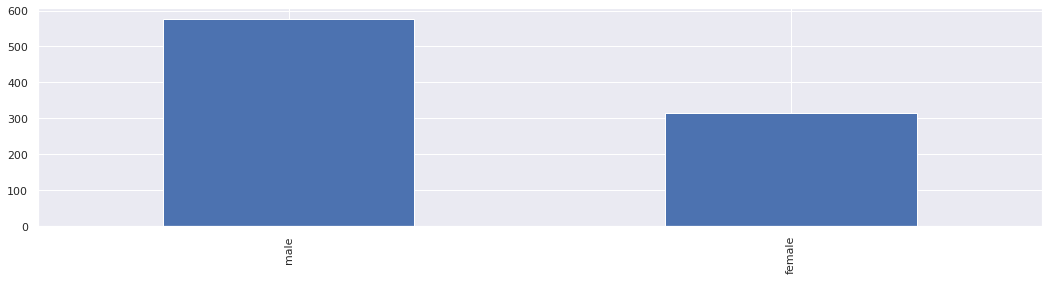

In [420]:
# соотношение мужщин и женщин
df.Sex.value_counts().plot.bar()

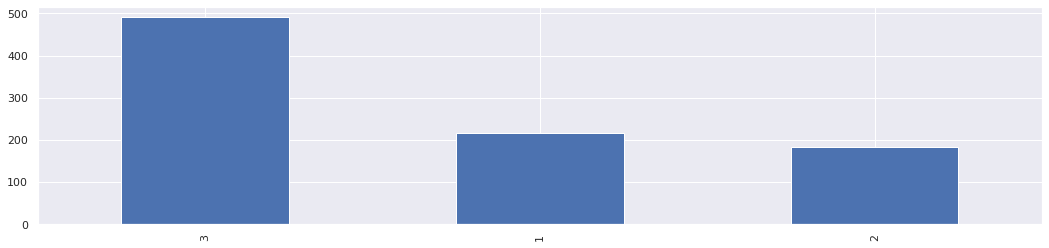

In [421]:
# соотношение пассажиров по классам
df.Pclass.value_counts().plot.bar()

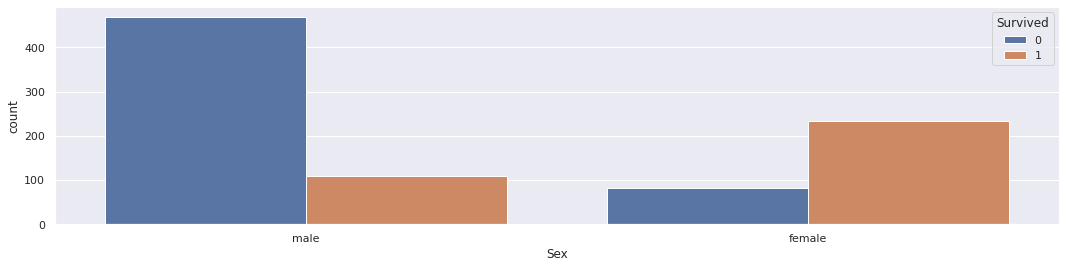

In [422]:
# "выживаемость" в зависимости от пола
sns.countplot(data=df, x='Sex', hue='Survived')

Шансов выжить у женщин больше.

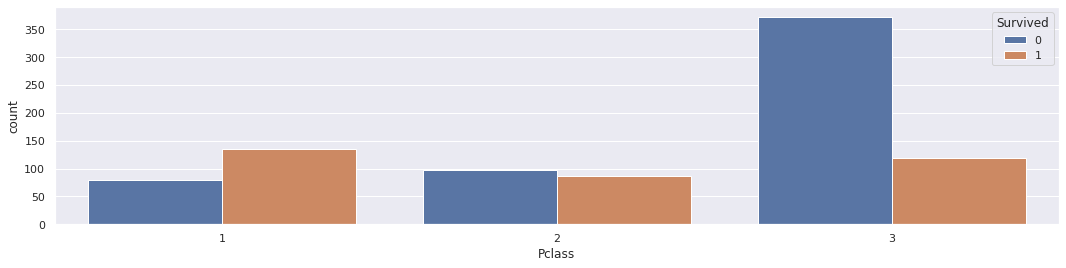

In [423]:
# "выживаемость" в зависимости от класса
sns.countplot(data=df, x='Pclass', hue='Survived')

Шансов выжить в первом классе больше.

### Обучение

In [424]:
# целевой признак
y = df.Survived
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [425]:
# признаки
X = df[features]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [426]:
# категориальные столбцы переведем в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [427]:
# разобьем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [428]:
comment='yes v1'
experiment(X_train,y_train, comment)

## Обучение с подготовкой данных, версия 2

Попробуем все же использовать признак "Cabin". Вместо пропущенных значений подставим какое-нибудь значение,  допустим 'empty' 

### Подготовка данных

In [429]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [430]:
df.loc[df.Cabin.isnull(), 'Cabin'] = 'empty'

In [431]:
# повторим подстановки с певрого варианта

age_ = df.groupby(['Pclass','Sex'])['Age'].mean()
df.loc[ (df.Age.isnull()) & (df.Pclass == 1) & (df.Sex == 'female'), 'Age'] = age_[1][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 1) & (df.Sex == 'male'), 'Age'] = age_[1][1]
df.loc[ (df.Age.isnull()) & (df.Pclass == 2) & (df.Sex == 'female'), 'Age'] = age_[2][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 2) & (df.Sex == 'male'), 'Age'] = age_[2][1]
df.loc[ (df.Age.isnull()) & (df.Pclass == 3) & (df.Sex == 'female'), 'Age'] = age_[3][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 3) & (df.Sex == 'male'), 'Age'] = age_[3][1]

embarked_ = df.Embarked.mode()
df.loc[ df.Embarked.isnull(), 'Embarked'] = embarked_[0]

In [432]:
# обновим список признаков, добавим Cabin
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']

### Обучение

In [433]:
# Разбиение по признакам
# целевой признак
y = df.Survived
# предикторы
X = df[features]

In [434]:
# категориальные столбцы переведем в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_empty
0,3,22.0,1,0,7.2500,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [435]:
# разобьем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [436]:
comment='yes v2'
experiment(X_train,y_train, comment)

#Обучение с подготовкой данных, версия 3

Попробуем еще раз поработать с признаком Age. Только в этот раз в предсказании будем использовать не сам возраст, а возрастную категорию, к которой относится пассажир.

In [437]:
# заново загрузим данные
df = pd.read_csv('train.csv')
# избавимся от признака Cabin
df.drop('Cabin', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [438]:
# подготовим функцию, у которой на вход подается возраст, а на выходе - возрастная группа
def age_group(age):
  if age > 0.0 and age <=2.0:
    return 'baby'
  elif age > 2.0 and age <= 16.0:
    return 'child'
  elif age > 16.0 and age <= 30.0:
    return 'young'
  elif age > 30.0 and age <= 45.0:
    return 'middle'
  elif age > 45.0 and age <= 60:
    return 'old'
  elif age > 60:
    return 'old+'

In [439]:
# добавим новый столбец
df['age_group'] = ''

In [440]:
# заполним признак в тех строках, где есть возраст
df.loc[~df.Age.isnull(), 'age_group'] = df.apply(lambda x: age_group(x['Age']), axis=1)

In [441]:
# посмотрим как распределились возрастные категории в зависимости от класса
age_groups_ = df[~df.Age.isnull()].groupby(['Pclass','age_group'])['age_group'].count()
age_groups_ 

Pclass  age_group
1       baby           2
        child          7
        middle        63
        old           48
        old+          14
        young         52
2       baby           7
        child         14
        middle        54
        old           20
        old+           3
        young         75
3       baby          15
        child         55
        middle        85
        old           13
        old+           5
        young        182
Name: age_group, dtype: int64

In [442]:
# заменим отсутствующие значения в признаке возрастной категории самым распространенным значением в соответсвующем классе
# подготовим для этого функцию
def age_group_insert(pclass):
  if pclass == 1:
    return 'middle'
  elif pclass == 2:
    return 'young'
  else:
    return 'young'

In [443]:
# заполним признак в тех строках, где пусто
df.loc[df.age_group=='', 'age_group'] = df.apply(lambda x: age_group_insert(x['Pclass']), axis=1)

In [444]:
# обновим список признаков, удалим Age, добавим age_group
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_group']

In [445]:
# Разбиение по признакам
# целевой признак
y = df.Survived
# предикторы
X = df[features]

In [446]:
# категориальные столбцы переведем в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(X)
X.head()

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_group_baby,age_group_child,age_group_middle,age_group_old,age_group_old+,age_group_young
0,3,1,0,7.2500,0,1,0,0,1,0,0,0,0,0,1
1,1,1,0,71.2833,1,0,1,0,0,0,0,1,0,0,0
2,3,0,0,7.9250,1,0,0,0,1,0,0,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,1,0,0,1,0,0,0
4,3,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0


In [447]:
# разобьем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [448]:
comment='yes v3'
experiment(X_train,y_train, comment)

# Результаты и выводы

In [449]:
results

,method,preprocessing,accuracy,f1,roc-auc
0,LogReg,no,0.797203,0.738739,0.829563
1,SVC,no,0.818182,0.775862,0.841468
2,LDA,no,0.776224,0.714286,0.823413
3,DecTree,no,0.699301,0.638655,0.699107
4,RandForest,no,0.762238,0.716667,0.838393
5,LogReg,yes v1,0.821229,0.774648,0.882625
6,SVC,yes v1,0.815642,0.755556,0.862677
7,LDA,yes v1,0.787709,0.736111,0.881596
8,DecTree,yes v1,0.793296,0.754967,0.791055
9,RandForest,yes v1,0.821229,0.780822,0.893501


Text(0.5, 0.98, 'Quality metrics by the method and preprocessing')

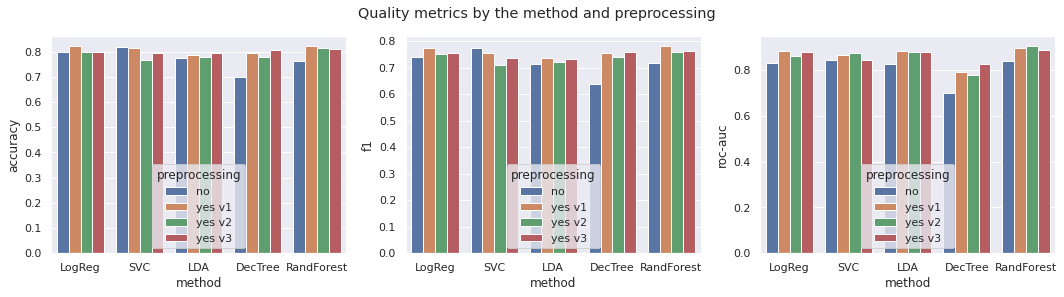

In [450]:
# Много цифр, визуализируем для удобства

sns.set(rc={"figure.figsize":(18, 4)})
fig, axes = plt.subplots(1, 3)
sns.barplot(data=results, x="method", y="accuracy", hue='preprocessing', ax=axes[0])
sns.barplot(data=results, x="method", y="f1", hue='preprocessing', ax=axes[1])
sns.barplot(data=results, x="method", y="roc-auc", hue='preprocessing', ax=axes[2])
fig.suptitle('Quality metrics by the method and preprocessing')

**Логистическая регрессия**. Наилучшие результаты показала первая версия подготовки данных. Все посчитанные метрики качества на нем показали более высокие результаты относительно других вариантов подготовки данных.

**Метод опорных векторов**. Неожиданно показал самые лучшие результаты по двум метрикам из трех на версии без подготовки данных (когда просто удалили записи с NaN). То есть получается (по двум метрикам из трех), он показал лучшие результат на меньшем количестве данных (зато на "честных", без подстановок).

**Линейный дисперсионный анализ**. С подготовкой данных получены более высокие метрики качества, чем без.

**Дерево решений**. Произошел значительный рост метрик с обработанными данными.Причем, этому методу больше всего "понравился" вариант, когда возраст перевели в категории. Что, по моему, логично, так как дереву проще работать с категориальными данными, чем с числовыми.

**Случайный лес**. Показал самые лучшие результаты среди всех использованных методов. Причем, в отличие от дерева, с версией номер один получились самые лучшие результаты.

Какие **выводы** в целом можно сделать. Важную роль играет и выбор подходящей для данной задачи метода обучения, и адекватной метрики качества, и предварительный анализ данных, и их предварительная подготовка. 

Как я понимаю, на данном этапе своего развития как DS, для решения конкртной задачи, нужно пробовать разные методы машинного обучения и способы подготовки данных, оценивать метрики качества и выбрать среди них наиболее оптимальный вариант. Далее уже работаем с выбранным вариантом, пробуем подбирать параметры, тюнить модель. 

По полученным результатам я бы выбрал Случайный лес с первой версией подготовки данных и продолжил тюнить эту модель.

Самым, трудоемким, как и говорилось на лекции, оказался процесс анализа и подготовки данных, в то время как непосредственно само обучение занимает очень мало времени.



## Случайный лес

Попытаемся немного улучшить эту модель. Для этого заново подгрузим и подготовим данные.

In [451]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [452]:
# избавимся от признака Cabin
df.drop('Cabin', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [453]:
# средний возраст в зависимости от класса и пола.
age_ = df.groupby(['Pclass','Sex'])['Age'].mean()
age_

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [454]:
# подставим полученные значения вместо пропусков

df.loc[ (df.Age.isnull()) & (df.Pclass == 1) & (df.Sex == 'female'), 'Age'] = age_[1][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 1) & (df.Sex == 'male'), 'Age'] = age_[1][1]

df.loc[ (df.Age.isnull()) & (df.Pclass == 2) & (df.Sex == 'female'), 'Age'] = age_[2][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 2) & (df.Sex == 'male'), 'Age'] = age_[2][1]

df.loc[ (df.Age.isnull()) & (df.Pclass == 3) & (df.Sex == 'female'), 'Age'] = age_[3][0]
df.loc[ (df.Age.isnull()) & (df.Pclass == 3) & (df.Sex == 'male'), 'Age'] = age_[3][1]

In [455]:
# Признак Embarked, всего два пропуска, заменим модой.
embarked_ = df.Embarked.mode()
# подстановка
df.loc[ df.Embarked.isnull(), 'Embarked'] = embarked_[0]

In [456]:
# целевой признак
y = df.Survived
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [457]:
# список признаков
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [458]:
# признаки
X = df[features]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [459]:
# категориальные столбцы переведем в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [460]:
# разобьем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

С помощью GridSearchCV постараемся подобрать наилучшие параметры.

In [478]:
# создаем модель с параметрами по умолчанию
model = RandomForestClassifier()

# подготовим словарь с параметрами для подбора
params = {'criterion':['gini', 'entropy'],
          'n_estimators': [100, 150, 200],
          'max_depth':[10, 15],
          'min_samples_split':[2, 5, 7]
          }

# создаем экземпляр класса и передаем в него параметры для перебора
search = GridSearchCV(model, params, cv=5, n_jobs = -1)

search.fit(X_train, y_train)

# посмотрим наилучший найденный параметр
search.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_split': 7,
 'n_estimators': 100}

In [488]:
# модель с найденными наилучшими параметрами
best_model = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split = 7, n_estimators = 100, random_state=42)
best_model.fit(X_train,y_train)
      
# предсказанные значения целевого признака
y_pred = best_model.predict(X_test)

# вероятности принадлежности к классам 0 и 1
y_pred_prob = best_model.predict_proba(X_test)

# метрика accuracy
acc_ = best_model.score(X_test,y_test)

# f1-метрика
f1_ = f1_score(y_test, y_pred)

# roc_auc_score
roc_ = roc_auc_score(y_test, y_pred_prob[:,1])

print(f'accuracy = {acc_}')
print(f'f1       = {f1_}') 
print(f'roc-auc  = {roc_}') 

accuracy = 0.8435754189944135
f1       = 0.8000000000000002
roc-auc  = 0.9018018018018018


Сравним с первоначальными метриками, полученными выше

In [482]:
results.loc[9]

method           RandForest
preprocessing        yes v1
accuracy           0.821229
f1                 0.780822
roc-auc            0.893501
Name: 9, dtype: object

Отлично! Еще немного удалось повысить качество модели.